## Chopping off high $d_L$
It looks like the peak finder dips down a little towards the end for some (currently unknown) reason. The temporary solution to this is to simply stop before that. We'll also do some sigma clipping later to see if the issue is actually just that the errors are too large that far away since $d_L$ is in the denominator of the error functions.

In [25]:
import numpy as np
from scipy.stats import gaussian_kde
import pymc as pm
from pylab import *
import arviz as az
from astropy.cosmology import Planck18
from tqdm import tqdm
import seaborn as sns
from MCMC_functions import *
from astropy.cosmology import units as cu
import pandas as pd

sns.set_context('notebook')
sns.set_palette('colorblind')

import matplotlib
matplotlib.rcParams['font.family'] = 'serif' # so these plots can go into thesis
matplotlib.rcParams['mathtext.fontset'] = 'dejavuserif'

%matplotlib inline

In [26]:
ms = generate_masses(f=0.5)
dLs = generate_dLs()
zs = dLs_to_zs(dLs)

m_det = ms*(1+zs)

## First up: Bootstrapping method

In [27]:
n_events = len(m_det)
n_dLs=10
n_mc = 8
m_min = min(m_det)
m_max = max(m_det)
dL_min = min(dLs)
dL_max = max(dLs)
cutoff_d = 22000 #Mpc

In [28]:
m_grid = np.exp(np.linspace(np.log(m_min), np.log(m_max), 1024))
# d_Ls_mc = np.random.lognormal(mean=np.log(dLs), sigma=sigma_dls)
d_low_dl = dLs[dLs < cutoff_d]
dL_cent = np.quantile(d_low_dl, np.linspace(0.01, 0.95, n_dLs))

DLG, MG = np.meshgrid(dL_cent, m_grid, indexing='ij')

mpeak_samples = np.zeros((n_mc, n_dLs))

100%|██████████| 8/8 [01:12<00:00,  9.12s/it]


(0.0, 29319.94182322402)

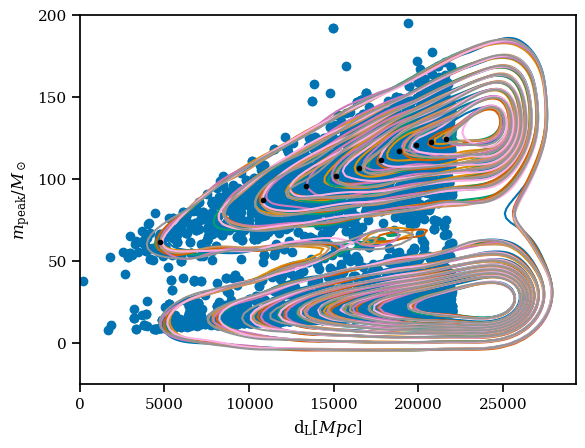

In [29]:
for run in tqdm(range(n_mc)):

    events = np.random.randint(n_events, size=n_events)
    
    m_dets = m_det[events]
    d_Ls = dLs[events]
    d_Ls_mc = d_Ls[d_Ls < cutoff_d]
    m_det_mc = m_dets[d_Ls < cutoff_d]
    
    arr = np.array([d_Ls, m_dets])
    kde = gaussian_kde(arr)
    
    pdf = kde(np.array([DLG.ravel(), MG.ravel()])).reshape(DLG.shape)
    for i in range(n_dLs):
        redshifted_min = 25*(1+cosmo.z_at_value(Planck18.luminosity_distance, dL_cent[i]*u.Mpc))
        mpeak_samples[run,i] = find_argmax_gridsearch(m_grid, pdf[i,:], mmin=redshifted_min)
    
    kplot = sns.kdeplot(x=d_Ls, y=m_dets)
    
plt.errorbar(dL_cent, np.mean(mpeak_samples, axis=0), 
             yerr=np.std(mpeak_samples, axis=0), fmt='.', c='k')
plt.scatter(d_Ls_mc, m_det_mc)
plt.xlabel(r'$\mathrm{d_L}[Mpc]$')
plt.ylabel(r'$m_\mathrm{peak} / M_\odot$')
plt.ylim(top=200)
plt.xlim(left=0)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
/Users/tanner/miniconda3/lib/python3.9/site-packages/pymc/step_methods/hmc/quadpotential.py:611: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w, Om, h, m0]


Sampling 2 chains for 4_000 tune and 4_000 draw iterations (8_000 + 8_000 draws total) took 137 seconds.
There were 85 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9022, but should be close to 0.95. Try to increase the number of tuning steps.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.


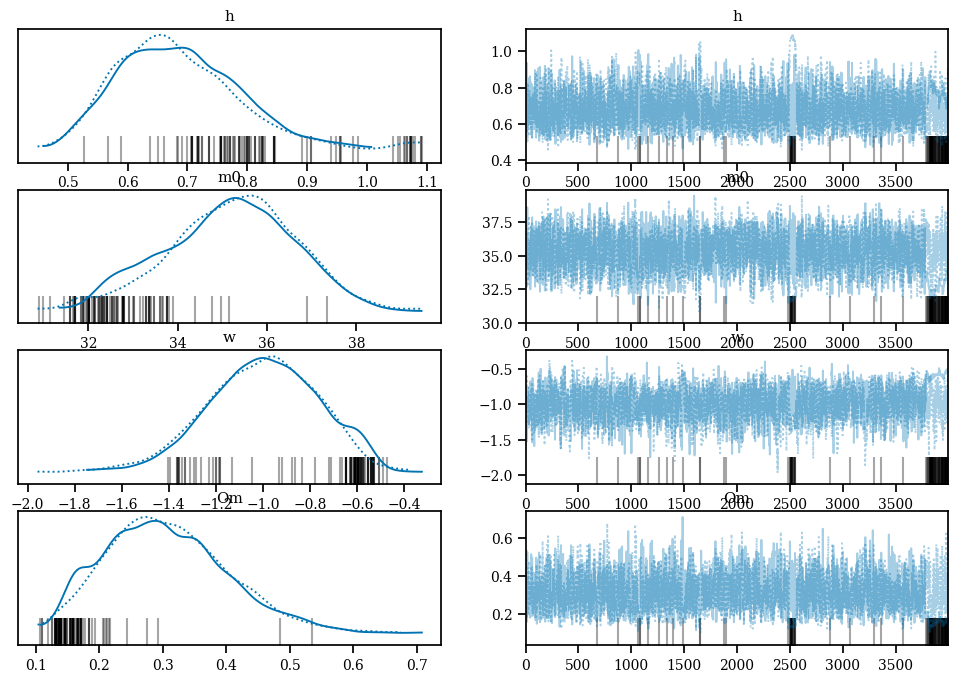

In [30]:
mu_ms = np.mean(mpeak_samples, axis=0)
sigma_ms = np.std(mpeak_samples, axis=0)


with make_model(ms_obs=mu_ms, sigma_ms_obs=sigma_ms, dls=dL_cent, zmin=0, zmax=3) as model:
    trace = pm.sample(target_accept=0.95, tune=4000, draws=4000, init='jitter+adapt_full')
    az.plot_trace(trace, var_names=['h', 'm0', 'w', 'Om'])
    trace.posterior['m_peak'] = trace.posterior.m0*(1+trace.posterior.zs) # Create another variable in the trace

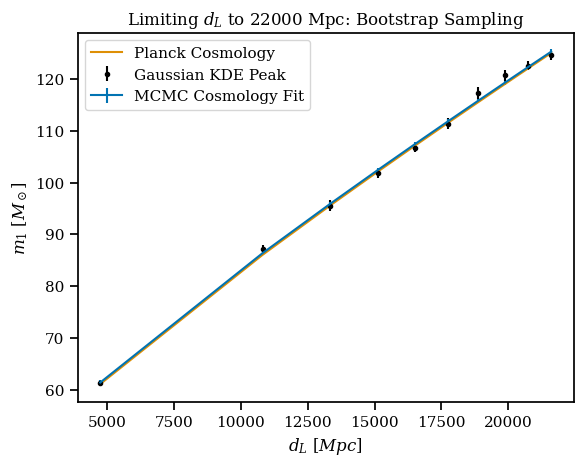

In [31]:
plt.errorbar(dL_cent, np.mean(mpeak_samples, axis=0), 
             yerr=np.std(mpeak_samples, axis=0),
             fmt='.', c='k', label="Gaussian KDE Peak")
plt.errorbar(dL_cent, trace.posterior['m_peak'].mean(dim=['chain', 'draw']),
              yerr=trace.posterior['m_peak'].std(dim=['chain', 'draw']),
              label="MCMC Cosmology Fit")
plt.plot(dL_cent, 35*(1+cosmo.z_at_value(Planck18.luminosity_distance, dL_cent*u.Mpc).value),
         label="Planck Cosmology")
plt.title(r"Limiting $d_L$ to %d Mpc: Bootstrap Sampling" % cutoff_d)
plt.ylabel(r"$m_1\ [M_\odot]$")
plt.xlabel(r"$d_L\ [Mpc]$")
plt.legend()

array([[<AxesSubplot:ylabel='Om'>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='h', ylabel='w'>, <AxesSubplot:xlabel='Om'>]],
      dtype=object)

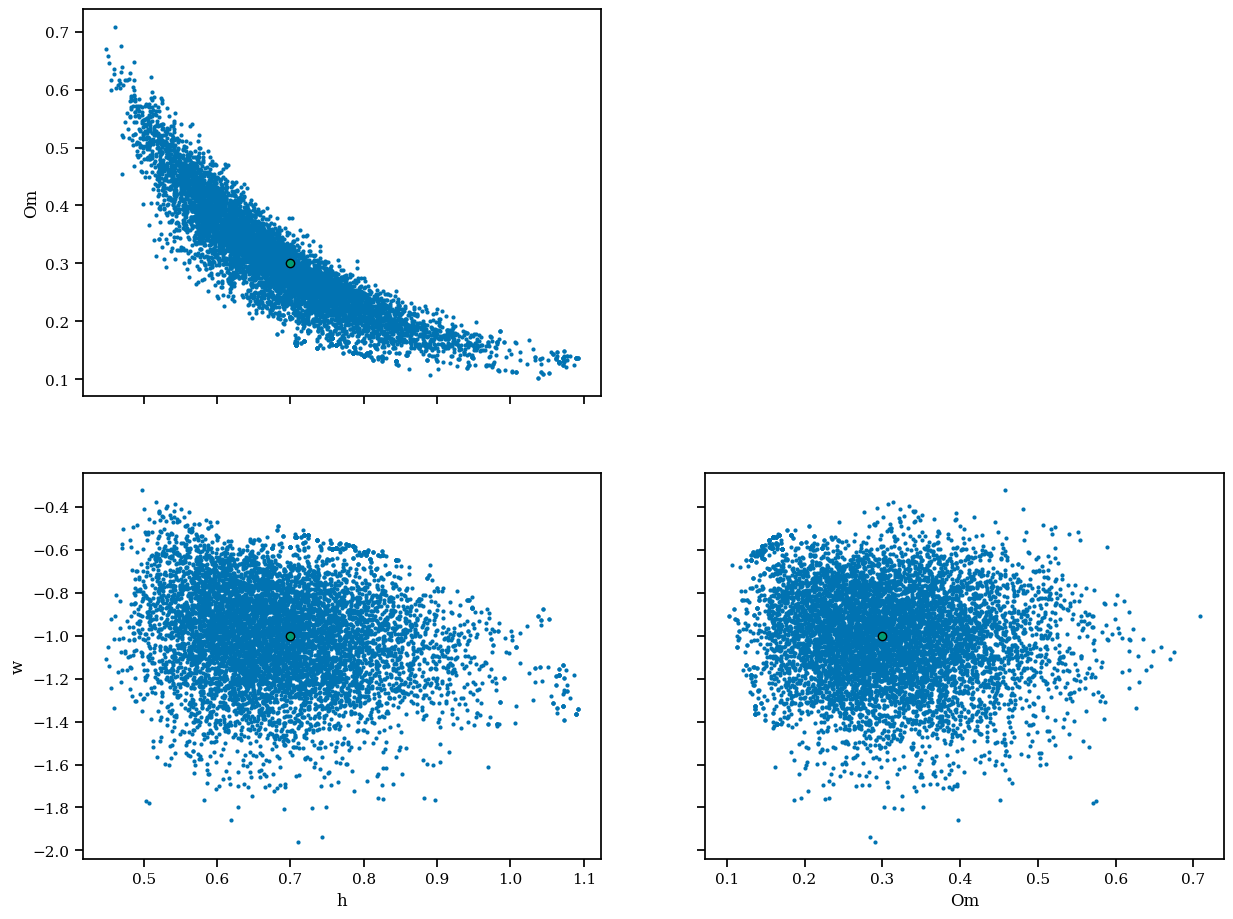

In [34]:
az.plot_pair(trace, var_names=['h', 'Om', 'w'], reference_values={'h': 0.7, 'Om':0.3, 'w':-1})

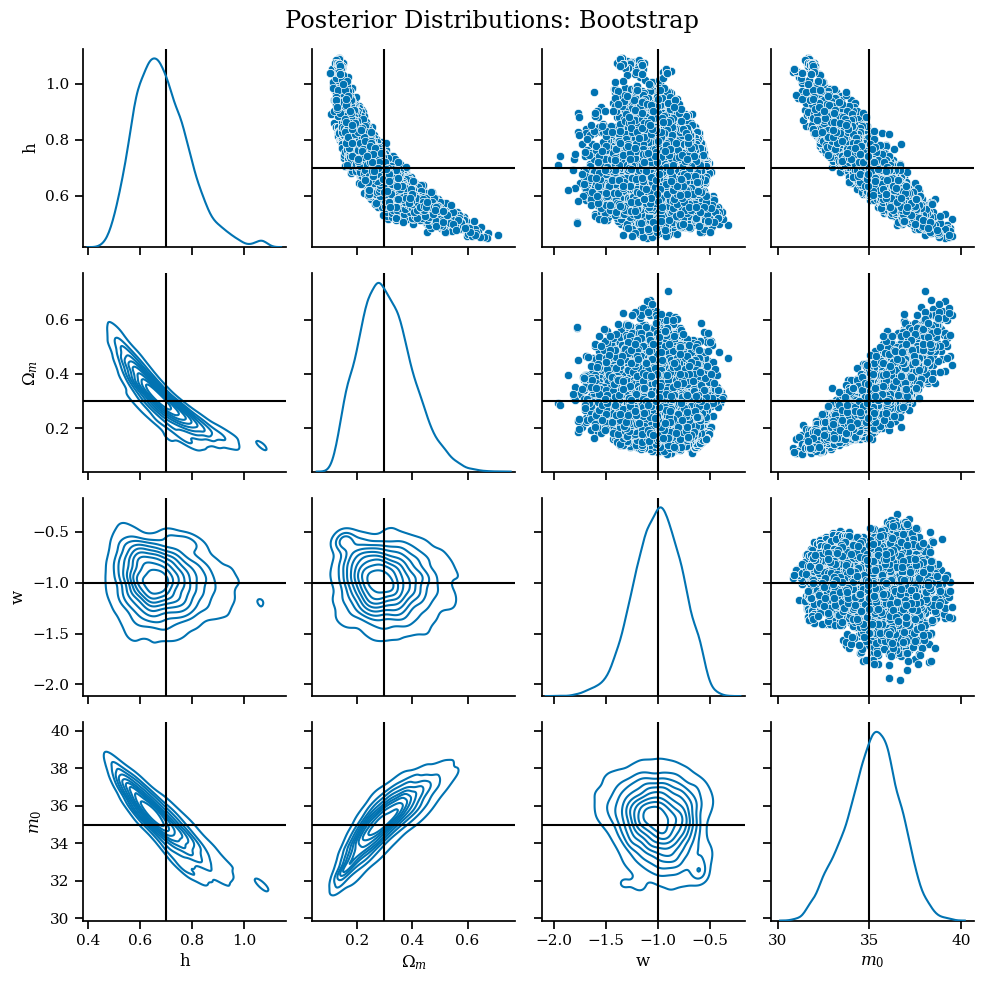

In [35]:
boot_df = trace.posterior[['h', 'Om', 'w', 'm0']].to_dataframe()

g = sns.PairGrid(boot_df, diag_sharey=False)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot)

replacements = {'Om': r'$\Omega_m$', 'm0': r'$m_0$'}
true_values = [0.7, 0.3, -1, 35]

for i in range(4):
    for j in range(4):
        xlabel = g.axes[i][j].get_xlabel()
        ylabel = g.axes[i][j].get_ylabel()
        if xlabel in replacements.keys():
            g.axes[i][j].set_xlabel(replacements[xlabel])
        if ylabel in replacements.keys():
            g.axes[i][j].set_ylabel(replacements[ylabel])
        if i == j:
            # Diagonal plots
            g.axes[i,j].axvline(true_values[i], color='k')
        else:
            g.axes[i,j].axvline(true_values[j], color='k') # Not sure if this is the right ordering of i (rows) and j (cols)
            g.axes[i,j].axhline(true_values[i], color='k')
g.figure.suptitle("Posterior Distributions: Bootstrap", size='x-large')
g.figure.tight_layout()

## Now trying the empirical errors method:

In [10]:
m_dls = m_det/dLs
sigma_dls = sigma_dL(m_dls)
sigma_ms  = sigma_m(m_dls)
print(len(sigma_ms))

10000


100%|██████████| 8/8 [01:03<00:00,  7.89s/it]


(-29.045555889963747, 250.0)

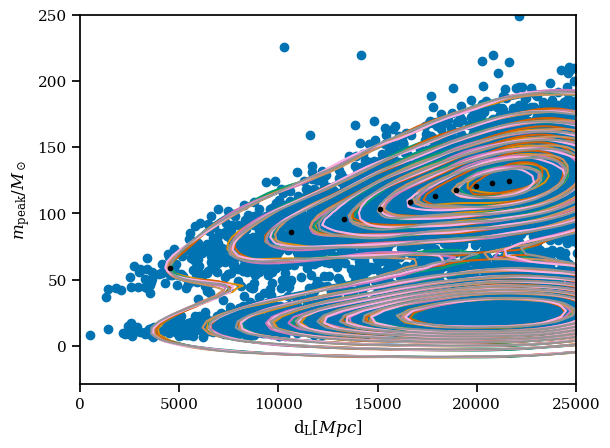

In [11]:
for run in tqdm(range(n_mc)):

    m_det_mc = np.random.lognormal(mean=np.log(m_det), sigma=sigma_ms)
    d_Ls_mc = np.random.lognormal(mean=np.log(dLs), sigma=sigma_dls)

    # m_det_mc = m_det_mc[d_Ls_mc < cutoff_d]
    # d_Ls_mc   = d_Ls_mc[d_Ls_mc < cutoff_d]
    
    arr = np.array([d_Ls_mc, m_det_mc])
    kde = gaussian_kde(arr)
    
    pdf = kde(np.array([DLG.ravel(), MG.ravel()])).reshape(DLG.shape)
    for i in range(n_dLs):
        redshifted_min = 25*(1+cosmo.z_at_value(Planck18.luminosity_distance, dL_cent[i]*u.Mpc))
        mpeak_samples[run,i] = find_argmax_gridsearch(m_grid, pdf[i,:], mmin=redshifted_min)
    
    kplot = sns.kdeplot(x=d_Ls_mc, y=m_det_mc)
    
plt.errorbar(dL_cent, np.mean(mpeak_samples, axis=0), 
             yerr=np.std(mpeak_samples, axis=0), fmt='.', c='k')
plt.scatter(d_Ls_mc, m_det_mc)
plt.xlabel(r'$\mathrm{d_L}[Mpc]$')
plt.ylabel(r'$m_\mathrm{peak} / M_\odot$')
plt.xlim(0,25000)
plt.ylim(top=250)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
Initializing NUTS using jitter+adapt_full...
/Users/tanner/miniconda3/lib/python3.9/site-packages/pymc/step_methods/hmc/quadpotential.py:611: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w, Om, h, m0]


Sampling 2 chains for 4_000 tune and 4_000 draw iterations (8_000 + 8_000 draws total) took 146 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.


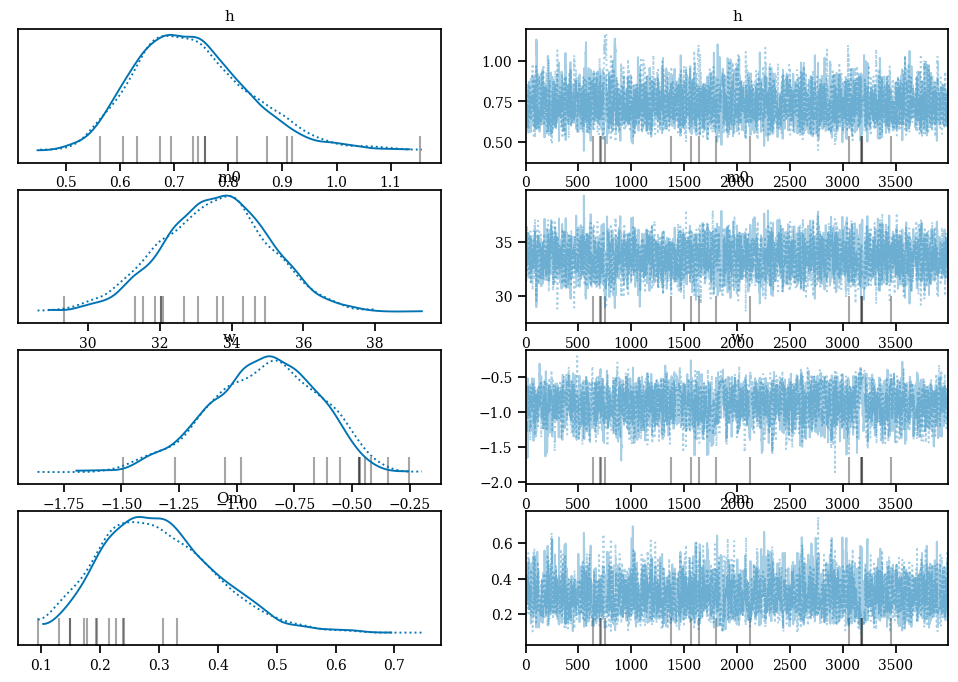

In [12]:
mu_ms = np.mean(mpeak_samples, axis=0)
sigmams = np.std(mpeak_samples, axis=0)


with make_model(ms_obs=mu_ms, sigma_ms_obs=sigmams, dls=dL_cent, zmin=0, zmax=3) as model:
    trace = pm.sample(target_accept=0.95, tune=4000, draws=4000, init='jitter+adapt_full')
    az.plot_trace(trace, var_names=['h', 'm0', 'w', 'Om'])
    trace.posterior['m_peak'] = trace.posterior.m0*(1+trace.posterior.zs) # Create another variable in the trace
    # err_df = trace.to_dataframe()

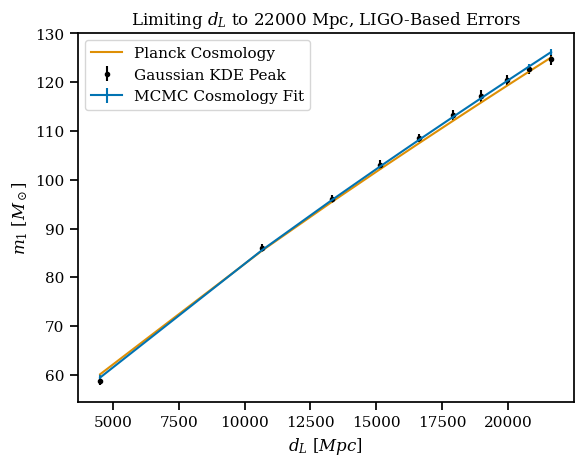

In [13]:
plt.errorbar(dL_cent, np.mean(mpeak_samples, axis=0), 
             yerr=np.std(mpeak_samples, axis=0),
             fmt='.', c='k', label="Gaussian KDE Peak")
plt.errorbar(dL_cent, trace.posterior['m_peak'].mean(dim=['chain', 'draw']),
              yerr=trace.posterior['m_peak'].std(dim=['chain', 'draw']),
              label="MCMC Cosmology Fit")
plt.plot(dL_cent, 35*(1+cosmo.z_at_value(Planck18.luminosity_distance, dL_cent*u.Mpc).value),
         label="Planck Cosmology")
plt.title(r"Limiting $d_L$ to %d Mpc, LIGO-Based Errors" % cutoff_d)
plt.ylabel(r"$m_1\ [M_\odot]$")
plt.xlabel(r"$d_L\ [Mpc]$")
plt.legend()

array([[<AxesSubplot:ylabel='Om'>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='h', ylabel='w'>, <AxesSubplot:xlabel='Om'>]],
      dtype=object)

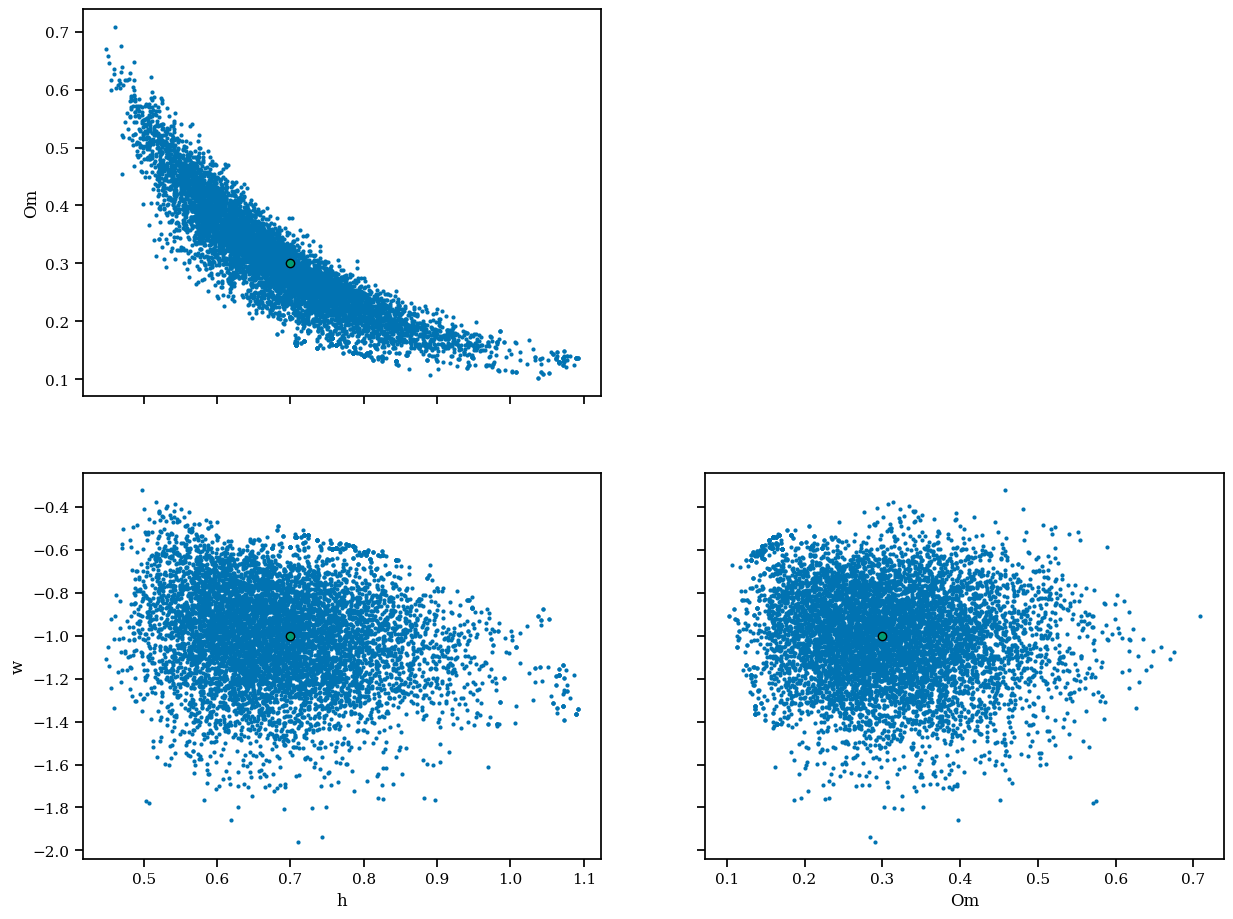

In [32]:
az.plot_pair(trace, var_names=['h', 'Om', 'w'], reference_values={'h': 0.7, 'Om':0.3, 'w':-1})

KeyboardInterrupt: 

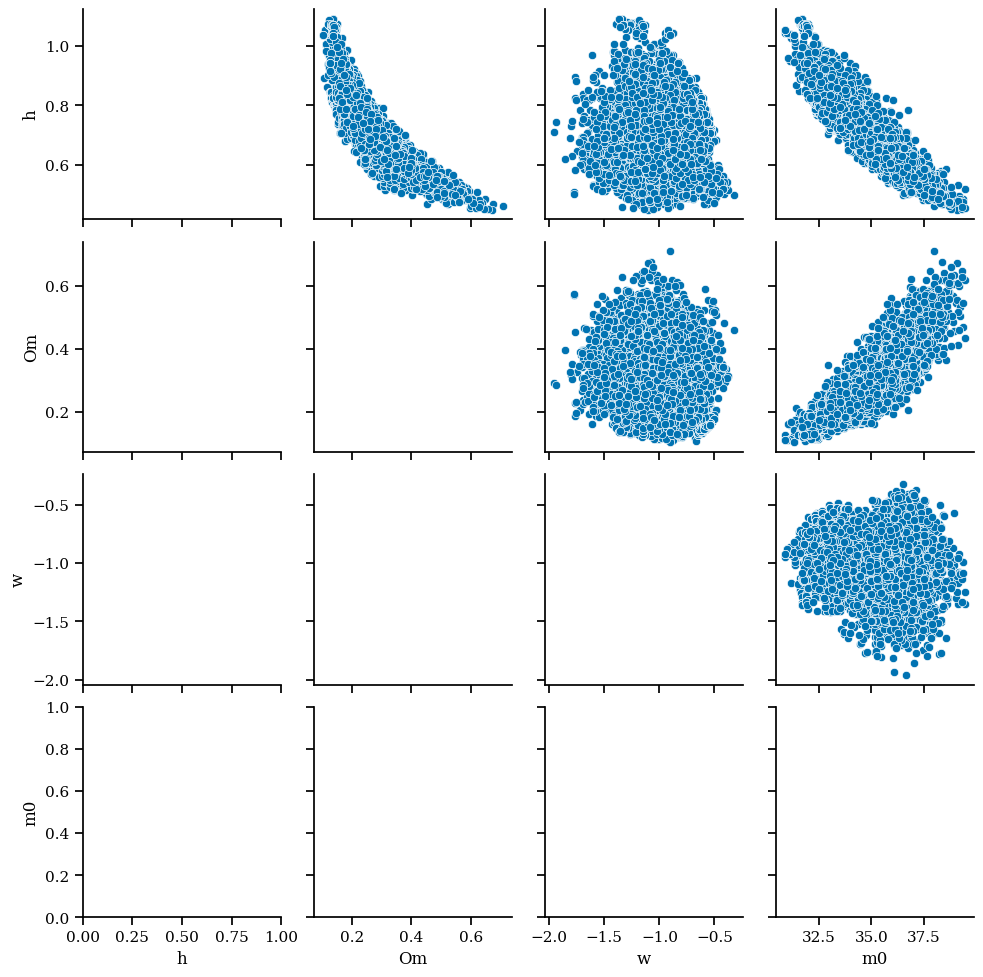

In [33]:
err_df = trace.posterior[['h', 'Om', 'w', 'm0']].to_dataframe()

g = sns.PairGrid(err_df, diag_sharey=False)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot)

replacements = {'Om': r'$\Omega_m$', 'm0': r'$m_0$'}
true_values = [0.7, 0.3, -1, 35]

for i in range(4):
    for j in range(4):
        xlabel = g.axes[i][j].get_xlabel()
        ylabel = g.axes[i][j].get_ylabel()
        if xlabel in replacements.keys():
            g.axes[i][j].set_xlabel(replacements[xlabel])
        if ylabel in replacements.keys():
            g.axes[i][j].set_ylabel(replacements[ylabel])
        if i == j:
            # Diagonal plots
            g.axes[i,j].axvline(true_values[i], color='k')
        else:
            g.axes[i,j].axvline(true_values[j], color='k') # Not sure if this is the right ordering of i (rows) and j (cols)
            g.axes[i,j].axhline(true_values[i], color='k')

g.figure.suptitle("Posterior Distributions: LIGO-Based Errors", size='x-large')
g.figure.tight_layout()